In [2]:
%cd

/home/iit


In [3]:
# Check cuda version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


# Importing RDKit

In [4]:
import os
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

try:
    import rdkit
    from rdkit import Chem
    from rdkit.Chem import Draw
    from rdkit.Chem import rdmolfiles
    from rdkit.Chem.Draw import IPythonConsole
    IPythonConsole.ipython_useSVG=True
except ImportError:
    print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
    exit()

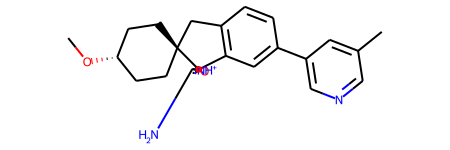

In [5]:
mol = Chem.MolFromSmiles('CO[C@@H]1CC[C@@]2(CC1)Cc1c([C@]32COC(=[NH+]3)N)cc(cc1)c1cncc(c1)C')
mol

# Importing required packages

In [6]:
import os
import gc
import sys
import time
import json
import math
import random
import argparse
import itertools
import numpy as np
import mxnet as mx
import pandas as pd
import networkx as nx
from scipy import sparse
from mxnet.gluon import nn
from collections import Counter
from mxnet.autograd import Function
from mxnet.gluon.data import Dataset
from mxnet import gluon, autograd, nd
from mxnet.gluon.data import DataLoader
from abc import ABCMeta, abstractmethod
from mxnet.gluon.data.sampler import Sampler

# Initializing hyperparameters

In [7]:
batch_size = 8   # training batch size
batch_size_test = 8   # test batch size
k = 5   # number of generation paths
p = 0.8   # randomness parameter alpha
F_e = 16    # initial hidden embedding size for each node in a graph
F_h = [32, 64, 128, 128, 256, 256]    # output sizes of each GCN layer
F_skip = 256    # size of skip connection layer
F_c = [512, ]   # hidden sizes of fully connected layers after graph convolution
Fh_policy = 128   # hidden size for policy layer
activation = 'relu'   # activation function
lr = 1e-3   # initial learning rate
decay = 1e-3    # initial weight decay
decay_step = 100    # perform decay after 100 steps
clip_grad = 3.0    # gradient clipping factor
summary_step = 500    # store model and training metrics after every certain no. of steps
N_rnn = 3   # number of layers used in GRUs
is_continuous = False   # load previous model or not
ckpt_dir = 'DGGNP/outputs/logs/'   # logs directory

# Reading data file

In [8]:
def read_data(file_name):
    smiles = []
    with open(file_name) as f:
        for line in f:
            smiles.append(line.strip())
    return smiles

In [9]:
ChEMBL = 'DGGNP/data/chembl/chembl.txt'
dataset = read_data(ChEMBL)

In [10]:
print(len(dataset))
print(type(dataset))
print(dataset[:5])
iterations = (len(dataset)//batch_size)*5    # training iterations
print(iterations)

1090529
<class 'list'>
['c1ccc(-n2cc(CNC3CCc4ncnn4C3)cn2)cc1', 'Cc1cccc(CCN2CCC[C@@H]2C)c1', 'CN(C)c1ccc(-c2cnc3c(N)ncnc3n2)cc1', 'CC(C)(C)C(=O)NCc1ccc(Cl)c(C(=O)Nc2nc(C(N)=O)c[nH]2)c1', 'COc1ccc2c(c1)sc1nc(-c3ccccc3)cn12']
681580


# Creating mini-batches

In [13]:
class BalancedSampler(Sampler):

    def __init__(self, cost, batch_size):
        index = np.argsort(cost).tolist()
        chunk_size = int(float(len(cost))/batch_size)
        self.index = []
        for i in range(batch_size):
            self.index.append(index[i*chunk_size:(i + 1)*chunk_size])

    def _g(self):
        # shuffle data
        for index_i in self.index:
            random.shuffle(index_i)

        for batch_index in zip(*self.index):
            yield batch_index

    def __iter__(self):
        return self._g()

    def __len__(self):
        return len(self.index[0])

# Obtaining all molecular properties

In [14]:
class MoleculeSpec(object):

    def __init__(self, file_name='DGGNP/data/atom_types.txt'):
        self.atom_types = []
        self.atom_symbols = []
        with open(file_name) as f:
            for line in f:
                atom_type_i = line.strip('\n').split(',')
                self.atom_types.append((atom_type_i[0], int(atom_type_i[1]), int(atom_type_i[2])))
                if atom_type_i[0] not in self.atom_symbols:
                    self.atom_symbols.append(atom_type_i[0])
        self.bond_orders = [Chem.BondType.AROMATIC,
                            Chem.BondType.SINGLE,
                            Chem.BondType.DOUBLE,
                            Chem.BondType.TRIPLE]
        self.max_iter = 120

    def get_atom_type(self, atom):
        atom_symbol = atom.GetSymbol()
        atom_charge = atom.GetFormalCharge()
        atom_hs = atom.GetNumExplicitHs()
        return self.atom_types.index((atom_symbol, atom_charge, atom_hs))

    def get_bond_type(self, bond):
        return self.bond_orders.index(bond.GetBondType())

    def index_to_atom(self, idx):
        atom_symbol, atom_charge, atom_hs = self.atom_types[idx]
        a = Chem.Atom(atom_symbol)
        a.SetFormalCharge(atom_charge)
        a.SetNumExplicitHs(atom_hs)
        return a

    def index_to_bond(self, mol, begin_id, end_id, idx):
        mol.AddBond(begin_id, end_id, self.bond_orders[idx])

    @property
    def num_atom_types(self):
        return len(self.atom_types)

    @property
    def num_bond_types(self):
        return len(self.bond_orders)

_mol_spec = None

def get_mol_spec():
    global _mol_spec
    if _mol_spec is None:
        _mol_spec = MoleculeSpec()
    return _mol_spec

# Defining utility functions for data preprocessing and postprocessing

In [15]:
def get_graph_from_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)

    # build graph
    atom_types, atom_ranks, bonds, bond_types = [], [], [], []
    for a, r in zip(mol.GetAtoms(), Chem.CanonicalRankAtoms(mol)):
        atom_types.append(get_mol_spec().get_atom_type(a))
        atom_ranks.append(r)
    for b in mol.GetBonds():
        idx_1, idx_2, bt = b.GetBeginAtomIdx(), b.GetEndAtomIdx(), get_mol_spec().get_bond_type(b)
        bonds.append([idx_1, idx_2])
        bond_types.append(bt)

    # build nx graph
    graph = nx.Graph()
    graph.add_nodes_from(range(len(atom_types)))
    graph.add_edges_from(bonds)

    return graph, atom_types, atom_ranks, bonds, bond_types


def get_graph_from_smiles_list(smiles_list):
    graph_list = []
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)

        # build graph
        atom_types, bonds, bond_types = [], [], []
        for a in mol.GetAtoms():
            atom_types.append(get_mol_spec().get_atom_type(a))
        for b in mol.GetBonds():
            idx_1, idx_2, bt = b.GetBeginAtomIdx(), b.GetEndAtomIdx(), get_mol_spec().get_bond_type(b)
            bonds.append([idx_1, idx_2])
            bond_types.append(bt)

        X_0 = np.array(atom_types, dtype=np.int32)
        A_0 = np.concatenate([np.array(bonds, dtype=np.int32),
                              np.array(bond_types, dtype=np.int32)[:, np.newaxis]],
                             axis=1)
        graph_list.append([X_0, A_0])
    return graph_list


def traverse_graph(graph, atom_ranks, current_node=None, step_ids=None, p=0.9, log_p=0.0):
    if current_node is None:
        next_nodes = range(len(atom_ranks))
        step_ids = [-1, ] * len(next_nodes)
        next_node_ranks = atom_ranks
    else:
        next_nodes = graph.neighbors(current_node)  # get neighbor nodes
        next_nodes = [n for n in next_nodes if step_ids[n] < 0] # filter visited nodes
        next_node_ranks = [atom_ranks[n] for n in next_nodes] # get ranks for neighbors
    next_nodes = [n for n, r in sorted(zip(next_nodes, next_node_ranks), key=lambda _x:_x[1])] # sort by rank

    # iterate through neighbors
    while len(next_nodes) > 0:
        if len(next_nodes)==1:
            next_node = next_nodes[0]
        elif random.random() >= (1 - p):
            next_node = next_nodes[0]
            log_p += np.log(p)
        else:
            next_node = next_nodes[random.randint(1, len(next_nodes) - 1)]
            log_p += np.log((1.0 - p) / (len(next_nodes) - 1))
        step_ids[next_node] = max(step_ids) + 1
        _, log_p = traverse_graph(graph, atom_ranks, next_node, step_ids, p, log_p)
        next_nodes = [n for n in next_nodes if step_ids[n] < 0] # filter visited nodes

    return step_ids, log_p


def single_reorder(X_0, A_0, step_ids):
    X_0, A_0 = np.copy(X_0), np.copy(A_0)

    step_ids = np.array(step_ids, dtype=np.int32)

    # sort by step_ids
    sorted_ids = np.argsort(step_ids)
    X_0 = X_0[sorted_ids]
    A_0[:, 0], A_0[:, 1] = step_ids[A_0[:, 0]], step_ids[A_0[:, 1]]
    max_b, min_b = np.amax(A_0[:, :2], axis=1), np.amin(A_0[:, :2], axis=1)
    A_0 = A_0[np.lexsort([-min_b, max_b]), :]

    # separate append and connect
    max_b, min_b = np.amax(A_0[:, :2], axis=1), np.amin(A_0[:, :2], axis=1)
    is_append = np.concatenate([np.array([True]), max_b[1:] > max_b[:-1]])
    A_0 = np.concatenate([np.where(is_append[:, np.newaxis],
                                 np.stack([min_b, max_b], axis=1),
                                 np.stack([max_b, min_b], axis=1)),
                        A_0[:, -1:]], axis=1)

    return X_0, A_0


def single_expand(X_0, A_0):
    X_0, A_0 = np.copy(X_0), np.copy(A_0)

    # expand X
    is_append_iter = np.less(A_0[:, 0], A_0[:, 1]).astype(np.int32)
    NX = np.cumsum(np.pad(is_append_iter, [[1, 0]], mode='constant', constant_values=1))
    shift = np.cumsum(np.pad(NX, [[1, 0]], mode='constant')[:-1])
    X_index = np.arange(NX.sum(), dtype=np.int32) - np.repeat(shift, NX)
    X = X_0[X_index]

    # expand A
    _, A_index = np.tril_indices(A_0.shape[0])
    A = A_0[A_index, :]
    NA = np.arange(A_0.shape[0] + 1)

    # get action
    # action_type, atom_type, bond_type, append_pos, connect_pos
    action_type = 1 - is_append_iter
    atom_type = np.where(action_type == 0, X_0[A_0[:, 1]], 0)
    bond_type = A_0[:, 2]
    append_pos = np.where(action_type == 0, A_0[:, 0], 0)
    connect_pos = np.where(action_type == 1, A_0[:, 1], 0)
    actions = np.stack([action_type, atom_type, bond_type, append_pos, connect_pos],
                       axis=1)
    last_action = [[2, 0, 0, 0, 0]]
    actions = np.append(actions, last_action, axis=0)

    action_0 = np.array([X_0[0]], dtype=np.int32)

    # }}}

    # {{{ Get mask
    last_atom_index = shift + NX - 1
    last_atom_mask = np.zeros_like(X)
    last_atom_mask[last_atom_index] = np.where(
        np.pad(is_append_iter, [[1, 0]], mode='constant', constant_values=1) == 1,
        np.ones_like(last_atom_index),
        np.ones_like(last_atom_index) * 2)
    # }}}

    return action_0, X, NX, A, NA, actions, last_atom_mask


def get_d(A, X):
    #print('row shape:', np.concatenate([A[:, 0], A[:, 1]], axis=0))
    #print('X.shape[0]:', [X.shape[0], ] * 2)

    _to_sparse = lambda _A, _X: sparse.coo_matrix((np.ones([_A.shape[0] * 2], dtype=np.int32),
                                                   (np.concatenate([_A[:, 0], _A[:, 1]], axis=0),
                                                    np.concatenate([_A[:, 1], _A[:, 0]], axis=0))),
                                                    shape=[_X.shape[0], ] * 2)
    
    
    A_sparse = _to_sparse(A, X)

    d2 = A_sparse * A_sparse
    d3 = d2 * A_sparse

    # get D_2
    D_2 = np.stack(d2.nonzero(), axis=1)
    D_2 = D_2[D_2[:, 0] < D_2[:, 1], :]

    # get D_3
    D_3 = np.stack(d3.nonzero(), axis=1)
    D_3 = D_3[D_3[:, 0] < D_3[:, 1], :]

    # remove D_1 elements from D_3
    D_3_sparse = _to_sparse(D_3, X)
    D_3_sparse = D_3_sparse - D_3_sparse.multiply(A_sparse)
    D_3 = np.stack(D_3_sparse.nonzero(), axis=1)
    D_3 = D_3[D_3[:, 0] < D_3[:, 1], :]

    return D_2, D_3


def merge_single_0(X_0, A_0, NX_0, NA_0):
    # shift_ids
    cumsum = np.cumsum(np.pad(NX_0, [[1, 0]], mode='constant')[:-1])
    A_0[:, :2] += np.stack([np.repeat(cumsum, NA_0), ] * 2, axis=1)

    # get D
    D_0_2, D_0_3 = get_d(A_0, X_0)

    # split A
    A_split = []
    for i in range(get_mol_spec().num_bond_types):
        A_i = A_0[A_0[:, 2] == i, :2]
        A_split.append(A_i)
    A_split.extend([D_0_2, D_0_3])
    A_0 = A_split

    # NX_rep
    NX_rep_0 = np.repeat(np.arange(NX_0.shape[0]), NX_0)

    return X_0, A_0, NX_0, NX_rep_0


def merge_single(X, A, NX, NA, mol_ids, rep_ids, iw_ids, action_0, actions, last_append_mask, log_p):
    X, A, NX, NX_rep = merge_single_0(X, A, NX, NA)
    cumsum = np.cumsum(np.pad(NX, [[1, 0]], mode='constant')[:-1])
    actions[:, -2] += cumsum * (actions[:, 0] == 0)
    actions[:, -1] += cumsum * (actions[:, 0] == 1)
    mol_ids_rep = np.repeat(mol_ids, NX)
    rep_ids_rep = np.repeat(rep_ids, NX)

    return X, A,\
           mol_ids_rep, rep_ids_rep, iw_ids,\
           last_append_mask,\
           NX, NX_rep,\
           action_0, actions, \
           log_p

def process_single(smiles, k, p):
    graph, atom_types, atom_ranks, bonds, bond_types = get_graph_from_smiles(smiles)

    # original
    X_0 = np.array(atom_types, dtype=np.int32)
    A_0 = np.concatenate([np.array(bonds, dtype=np.int32),
                          np.array(bond_types, dtype=np.int32)[:, np.newaxis]], axis=1)

    X, A = [], []
    NX, NA = [], []
    mol_ids, rep_ids, iw_ids = [], [], []
    action_0, actions = [], []
    last_append_mask = []
    log_p = []

    # random sampling decoding route
    for i in range(k):
        step_ids_i, log_p_i = traverse_graph(graph, atom_ranks, p=p)
        X_i, A_i = single_reorder(X_0, A_0, step_ids_i)
        action_0_i, X_i, NX_i, A_i, NA_i, actions_i, last_atom_mask_i = single_expand(X_i, A_i)

        # appends
        X.append(X_i)
        A.append(A_i)
        NX.append(NX_i)
        NA.append(NA_i)
        action_0.append(action_0_i)
        actions.append(actions_i)
        last_append_mask.append(last_atom_mask_i)

        mol_ids.append(np.zeros_like(NX_i, dtype=np.int32))
        rep_ids.append(np.ones_like(NX_i, dtype=np.int32) * i)
        iw_ids.append(np.ones_like(NX_i, dtype=np.int32) * i)

        log_p.append(log_p_i)

    # concatenate
    X = np.concatenate(X, axis=0)
    A = np.concatenate(A, axis = 0)
    NX = np.concatenate(NX, axis = 0)
    NA = np.concatenate(NA, axis = 0)
    action_0 = np.concatenate(action_0, axis = 0)
    actions = np.concatenate(actions, axis = 0)
    last_append_mask = np.concatenate(last_append_mask, axis = 0)
    mol_ids = np.concatenate(mol_ids, axis = 0)
    rep_ids = np.concatenate(rep_ids, axis = 0)
    iw_ids = np.concatenate(iw_ids, axis = 0)
    log_p = np.array(log_p, dtype=np.float32)

    return X, A, NX, NA, mol_ids, rep_ids, iw_ids, action_0, actions, last_append_mask, log_p


# noinspection PyArgumentList
def get_mol_from_graph(X, A, sanitize=True):
    try:
        mol = Chem.RWMol(Chem.Mol())

        X, A = X.tolist(), A.tolist()
        for i, atom_type in enumerate(X):
            mol.AddAtom(get_mol_spec().index_to_atom(atom_type))

        for atom_id1, atom_id2, bond_type in A:
            get_mol_spec().index_to_bond(mol, atom_id1, atom_id2, bond_type)
    except:
        return None

    if sanitize:
        try:
            mol = mol.GetMol()
            Chem.SanitizeMol(mol)
            return mol
        except:
            return None
    else:
        return mol

def get_mol_from_graph_list(graph_list, sanitize=True):
    mol_list = [get_mol_from_graph(X, A, sanitize) for X, A in graph_list]
    return mol_list

# Defining functions for loading data on GPU

In [16]:
class MolLoader(DataLoader):
    """Load graph based molecule representation from SMILES"""
    def __init__(self, dataset, batch_size=10, num_workers=0,
                 k=10, p=0.9, shuffle=False, sampler=None, batch_sampler=None):
        self.k = k
        self.p = p

        # batch_sampler, sampler and shuffle are mutually exclusive
        if batch_sampler is not None:
            super(MolLoader, self).__init__(dataset, batch_sampler=batch_sampler,
                                            num_workers=num_workers, batchify_fn=self._collate_fn)
        elif sampler is not None:
            super(MolLoader, self).__init__(dataset, sampler=sampler,
                                            num_workers=num_workers, batchify_fn=self._collate_fn,
                                            last_batch='rollover')
        else:
            super(MolLoader, self).__init__(dataset, batch_size, shuffle=shuffle,
                                            num_workers=num_workers, batchify_fn=self._collate_fn,
                                            last_batch='rollover')


    def _collate_fn(self, batch):
        # names = X, A,
        #         NX, NA,
        #         mol_ids, rep_ids, iw_ids,
        #         action_0, actions,
        #         last_append_mask,
        #         log_p

        shapes = [[0], [0, 3],
                  [0], [0],
                  [0], [0], [0],
                  [0], [0, 5],
                  [0],
                  [0]]
        dtypes = [np.int32, np.int32,
                  np.int32, np.int32,
                  np.int32, np.int32, np.int32,
                  np.int32, np.int32,
                  np.int32,
                  np.float32]

        _build = lambda: [np.zeros(shape=s, dtype=d) for s, d in zip(shapes, dtypes)]
        _append = lambda _r0, _r1: [np.concatenate([__r0, __r1], axis=0)
                                    for __r0, __r1 in zip(_r0, _r1)]

        X, A, \
        NX, NA, \
        mol_ids, rep_ids, iw_ids, \
        action_0, actions, \
        last_append_mask, \
        log_p = _build()


        for i, record_in in enumerate(batch):
            smiles = record_in

            X_i, A_i, \
            NX_i, NA_i, \
            mol_ids_i, rep_ids_i, iw_ids_i, \
            action_0_i, actions_i, \
            last_append_mask_i, log_p_i = process_single(smiles, self.k, self.p)
            
            if i != 0:
                mol_ids_i += mol_ids[-1] + 1
                iw_ids_i += iw_ids[-1] + 1

            X, A, \
            NX, NA, \
            mol_ids, rep_ids, iw_ids, \
            action_0, actions, \
            last_append_mask, \
            log_p = _append([X, A,
                             NX, NA,
                             mol_ids, rep_ids, iw_ids,
                             action_0, actions,
                             last_append_mask,
                             log_p],
                            [X_i, A_i,
                             NX_i, NA_i,
                             mol_ids_i, rep_ids_i, iw_ids_i,
                             action_0_i, actions_i,
                             last_append_mask_i,
                             log_p_i])

        X, A, \
        mol_ids_rep, rep_ids_rep, iw_ids, \
        last_append_mask, \
        NX, NX_rep, \
        action_0, actions, \
        log_p = merge_single(X, A,
                                   NX, NA,
                                   mol_ids, rep_ids, iw_ids,
                                   action_0, actions,
                                   last_append_mask,
                                   log_p)

        result_out = [X, A,
                      mol_ids_rep, rep_ids_rep, iw_ids,
                      last_append_mask,
                      NX, NX_rep,
                      action_0, actions,
                      log_p]

        return result_out

    @staticmethod
    def from_numpy_to_tensor(record):
        """Convert numpy to tensor and place it to a specific device"""
        [X, A,
         mol_ids_rep, rep_ids_rep, iw_ids,
         last_append_mask,
         NX, NX_rep,
         action_0, actions,
         log_p] = record

        X = nd.array(X, ctx=mx.gpu(), dtype='int32')
        A_sparse = []
        for A_i in A:
            if A_i.shape[0] == 0:
                A_sparse.append(None)
            else:
                # transpose may not be supported in gpu
                A_i = np.concatenate([A_i, A_i[:, [1, 0]]], axis=0)

                # construct csr matrix ...
                data = np.ones((A_i.shape[0], ), dtype=np.float32)
                row, col = A_i[:, 0], A_i[:, 1]
                A_sparse_i = nd.sparse.csr_matrix((data, (row, col)),
                                                  shape=tuple([int(X.shape[0]), ]*2),
                                                  ctx=mx.gpu(),
                                                  dtype='float32')

                # append to list
                A_sparse.append(A_sparse_i)

        batch_size, iw_size = (mol_ids_rep.max() + 1).item(), \
                              (rep_ids_rep.max() + 1).item()

        mol_ids_rep, rep_ids_rep, iw_ids, \
        last_append_mask, \
        NX, NX_rep, action_0, actions = [nd.array(_x, ctx=mx.gpu(), dtype='int32')
                                         for _x in [mol_ids_rep, rep_ids_rep, iw_ids,
                                                    last_append_mask,
                                                    NX, NX_rep, action_0, actions]]

        log_p = nd.array(log_p, ctx=mx.gpu(), dtype='float32')

        record = [X, A_sparse, iw_ids, last_append_mask,
                  NX, NX_rep, action_0, actions, log_p,
                  batch_size, iw_size]


        return record


class MolRNNLoader(MolLoader):

    def _collate_fn(self, batch):
        result_out = super(MolRNNLoader, self)._collate_fn(batch)

        # things ready for rnn
        mol_list = [Chem.MolFromSmiles(batch_i) for batch_i in batch]
        # preparing mapping
        graph_to_rnn = np.zeros((len(batch), self.k, get_mol_spec().max_iter), dtype=np.int32)
        rnn_to_graph = []
        cum_sum = 0
        for i, mol_i in enumerate(mol_list):
            num_iter = mol_i.GetNumBonds() + 1
            for k in range(self.k):
                graph_to_rnn[i, k, :num_iter] = (np.arange(num_iter) + cum_sum)

                rnn_to_graph_0 = np.ones([num_iter,], dtype=np.int32) * i
                rnn_to_graph_1 = np.ones_like(rnn_to_graph_0) * k
                rnn_to_graph_2 = np.arange(num_iter)
                rnn_to_graph.append(np.stack([rnn_to_graph_0, rnn_to_graph_1, rnn_to_graph_2], axis=0))

                cum_sum += num_iter
        rnn_to_graph = np.concatenate(rnn_to_graph, axis=1)
        NX_cum = np.cumsum(result_out[6])

        result_out = result_out + [graph_to_rnn, rnn_to_graph, NX_cum]

        return result_out

    @staticmethod
    def from_numpy_to_tensor(record):
        [X, A,
         mol_ids_rep, rep_ids_rep, iw_ids,
         last_append_mask,
         NX, NX_rep,
         action_0, actions,
         log_p,
         graph_to_rnn, rnn_to_graph, NX_cum] = record

        output = MolLoader.from_numpy_to_tensor([X, A,
                                                 mol_ids_rep, rep_ids_rep, iw_ids,
                                                 last_append_mask,
                                                 NX, NX_rep,
                                                 action_0, actions,
                                                 log_p])

        graph_to_rnn, rnn_to_graph, NX_cum =\
            nd.array(graph_to_rnn, ctx=mx.gpu(), dtype='int32'),\
            nd.array(rnn_to_graph, ctx=mx.gpu(), dtype='int32'), \
            nd.array(NX_cum, ctx=mx.gpu(), dtype='int32')

        output = output + [graph_to_rnn, rnn_to_graph, NX_cum]

        return output

# Defining graph convolution and other functions

In [17]:
class GraphConvFn(Function):

    def __init__(self, A):
        self.A = A # type: nd.sparse.CSRNDArray
        self.A_T = self.A # assume symmetric
        super(GraphConvFn, self).__init__()

    def forward(self, X):
        if self.A is not None:
            if len(X.shape) > 2:
                X_resized = X.reshape((X.shape[0], -1))
                output = nd.sparse.dot(self.A, X_resized)
                output = output.reshape([-1, ] + [X.shape[i] for i in range(1, len(X.shape))])
            else:
                output = nd.sparse.dot(self.A, X)
            return output
        else:
            return nd.zeros_like(X)

    def backward(self, grad_output):

        if self.A is not None:
            if len(grad_output.shape) > 2:
                grad_output_resized = grad_output.reshape((grad_output.shape[0], -1))
                grad_input = nd.sparse.dot(self.A_T, grad_output_resized)
                grad_input = grad_input.reshape([-1] + [grad_output.shape[i]
                                                        for i in range(1, len(grad_output.shape))])
            else:
                grad_input = nd.sparse.dot(self.A_T, grad_output)
            return grad_input
        else:
            return nd.zeros_like(grad_output)


class EfficientGraphConvFn(Function):
    """Save memory by re-computation"""

    def __init__(self, A_list):
        self.A_list = A_list
        super(EfficientGraphConvFn, self).__init__()

    def forward(self, X, W):
        X_list = [X]
        for A in self.A_list:
            if A is not None:
                X_list.append(nd.sparse.dot(A, X))
            else:
                X_list.append(nd.zeros_like(X))
        X_out = nd.concat(*X_list, dim=1)
        self.save_for_backward(X, W)

        return nd.dot(X_out, W)

    def backward(self, grad_output):
        X, W = self.saved_tensors

        # recompute X_out
        X_list = [X, ]
        for A in self.A_list:
            if A is not None:
                X_list.append(nd.sparse.dot(A, X))
            else:
                X_list.append(nd.zeros_like(X))
        X_out = nd.concat(*X_list, dim=1)

        grad_W = nd.dot(X_out.T, grad_output)

        grad_X_out = nd.dot(grad_output, W.T)
        grad_X_out_list = nd.split(grad_X_out, num_outputs=len(self.A_list) + 1)


        grad_X = [grad_X_out_list[0], ]
        for A, grad_X_out in zip(self.A_list, grad_X_out_list[1:]):
            if A is not None:
                grad_X.append(nd.sparse.dot(A, grad_X_out))
            else:
                grad_X.append(nd.zeros_like(grad_X_out))

        grad_X = sum(grad_X)

        return grad_X, grad_W


class SegmentSumFn(GraphConvFn):

    def __init__(self, idx, num_seg):
        # build A
        # construct coo
        data = nd.ones(idx.shape[0], ctx=idx.context, dtype='int32')
        row, col = idx, nd.arange(idx.shape[0], ctx=idx.context, dtype='int32')
        shape = (num_seg, int(idx.shape[0]))
        sparse = nd.sparse.csr_matrix((data, (row, col)), shape=shape,
                                      ctx=idx.context, dtype='float32')
        super(SegmentSumFn, self).__init__(sparse)

        sparse = nd.sparse.csr_matrix((data, (col, row)), shape=(shape[1], shape[0]),
                                      ctx=idx.context, dtype='float32')
        self.A_T = sparse


def squeeze(input, axis):
    assert input.shape[axis] == 1

    new_shape = list(input.shape)
    del new_shape[axis]

    return input.reshape(new_shape)


def unsqueeze(input, axis):
    return nd.expand_dims(input, axis=axis)


def logsumexp(inputs, axis=None, keepdims=False):
    """Numerically stable logsumexp.
    Args:
        inputs: A Variable with any shape.
        axis: An integer.
        keepdims: A boolean.
    Returns:
        Equivalent of log(sum(exp(inputs), dim=dim, keepdim=keepdim)).
    Adopted from: https://github.com/pytorch/pytorch/issues/2591
    """
    # For a 1-D array x (any array along a single dimension),
    # log sum exp(x) = s + log sum exp(x - s)
    # with s = max(x) being a common choice.
    if axis is None:
        inputs = inputs.reshape([-1])
        axis = 0
    s = nd.max(inputs, axis=axis, keepdims=True)
    outputs = s + (inputs - s).exp().sum(axis=axis, keepdims=True).log()
    if not keepdims:
        outputs = nd.sum(outputs, axis=axis, keepdims=False)
    return outputs


def get_activation(name):
    activation_dict = {
        'relu':nd.relu,
        'tanh':nd.tanh
    }
    return activation_dict[name]

# Defining neural networks

In [18]:
class Linear_BN(nn.Sequential):
    def __init__(self, F_in, F_out):
        super(Linear_BN, self).__init__()
        self.add(nn.Dense(F_out, in_units=F_in, use_bias=False))
        self.add(BatchNorm(in_channels=F_out))


class GraphConv(nn.Block):

    def __init__(self, Fin, Fout, D):
        super(GraphConv, self).__init__()

        # model settings
        self.Fin = Fin
        self.Fout = Fout
        self.D = D

        # model parameters
        self.W = self.params.get('w', shape=(self.Fin * (self.D + 1), self.Fout),
                                 init=None, allow_deferred_init=False)

    def forward(self, X, A_list):
        try:
            assert len(A_list) == self.D
        except AssertionError as e:
            print(self.D, len(A_list))
            raise e
        return EfficientGraphConvFn(A_list)(X, self.W.data(X.context))


class Policy(nn.Block):

    def __init__(self, F_in, F_h, N_A, N_B, k=1):
        super(Policy, self).__init__()
        self.F_in = F_in # number of input features for each atom
        self.F_h = F_h # number of context variables
        self.N_A = N_A # number of atom types
        self.N_B = N_B # number of bond types
        self.k = k # number of softmax used in the mixture


        with self.name_scope():
            self.linear_h = Linear_BN(F_in * 2, self.F_h * k)
            self.linear_h_t = Linear_BN(F_in, self.F_h * k)

            self.linear_x = nn.Dense(self.N_B + self.N_B*self.N_A, in_units=self.F_h)
            self.linear_x_t = nn.Dense(1, in_units=self.F_h)

            if self.k > 1:
                self.linear_pi = nn.Dense(self.k, in_units=self.F_in)
            else:
                self.linear_pi = None

    def forward(self, X, NX, NX_rep, X_end=None):
        # segment mean for X
        if X_end is None:
            X_end = SegmentSumFn(NX_rep, NX.shape[0])(X)/nd.cast(unsqueeze(NX, 1), 'float32')
        X = nd.concat(X, X_end[NX_rep, :], dim=1)

        X_h = nd.relu(self.linear_h(X)).reshape([-1, self.F_h])
        X_h_end = nd.relu(self.linear_h_t(X_end)).reshape([-1, self.F_h])

        X_x = nd.exp(self.linear_x(X_h)).reshape([-1, self.k, self.N_B + self.N_B*self.N_A])
        X_x_end = nd.exp(self.linear_x_t(X_h_end)).reshape([-1, self.k, 1])

        X_sum = nd.sum(SegmentSumFn(NX_rep, NX.shape[0])(X_x), -1, keepdims=True) + X_x_end
        X_sum_gathered = X_sum[NX_rep, :, :]

        X_softmax = X_x / X_sum_gathered
        X_softmax_end = X_x_end/ X_sum

        if self.k > 1:
            pi = unsqueeze(nd.softmax(self.linear_pi(X_end), axis=1), -1)
            pi_gathered = pi[NX_rep, :, :]

            X_softmax = nd.sum(X_softmax * pi_gathered, axis=1)
            X_softmax_end = nd.sum(X_softmax_end * pi, axis=1)
        else:
            X_softmax = squeeze(X_softmax, 1)
            X_softmax_end = squeeze(X_softmax_end, 1)

        # generate output probabilities
        connect, append = X_softmax[:, :self.N_B], X_softmax[:, self.N_B:]
        append = append.reshape([-1, self.N_A, self.N_B])
        end = squeeze(X_softmax_end, -1)

        return append, connect, end


class BatchNorm(nn.Block):

    def __init__(self, in_channels, momentum=0.9, eps=1e-5):
        super(BatchNorm, self).__init__()
        self.F = in_channels

        self.bn_weight = self.params.get('bn_weight', shape=(self.F,), init=mx.init.One(),
                                         allow_deferred_init=False)
        self.bn_bias = self.params.get('bn_bias', shape=(self.F,), init=mx.init.Zero(),
                                       allow_deferred_init=False)

        self.running_mean = self.params.get('running_mean', grad_req='null',
                                            shape=(self.F,),
                                            init=mx.init.Zero(),
                                            allow_deferred_init=False,
                                            differentiable=False)
        self.running_var = self.params.get('running_var', grad_req='null',
                                           shape=(self.F,),
                                           init=mx.init.One(),
                                           allow_deferred_init=False,
                                           differentiable=False)
        self.momentum = momentum
        self.eps = eps

    def forward(self, x):
        if autograd.is_training():
            return nd.BatchNorm(x,
                                gamma=self.bn_weight.data(x.context),
                                beta=self.bn_bias.data(x.context),
                                moving_mean=self.running_mean.data(x.context),
                                moving_var=self.running_var.data(x.context),
                                eps=self.eps, momentum=self.momentum,
                                use_global_stats=False)
        else:
            return nd.BatchNorm(x,
                                gamma=self.bn_weight.data(x.context),
                                beta=self.bn_bias.data(x.context),
                                moving_mean=self.running_mean.data(x.context),
                                moving_var=self.running_var.data(x.context),
                                eps=self.eps, momentum=self.momentum,
                                use_global_stats=True)

# Building generative network

In [19]:
class MoleculeGenerator(nn.Block):

    __metaclass__ = ABCMeta

    def __init__(self, N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation,
                 *args, **kwargs):
        super(MoleculeGenerator, self).__init__()
        self.N_A = N_A
        self.N_B = N_B
        self.D = D
        self.F_e = F_e
        self.F_skip = F_skip
        self.F_c = list(F_c) if isinstance(F_c, tuple) else F_c
        self.Fh_policy = Fh_policy
        self.activation = get_activation(activation)

        with self.name_scope():
            # embeddings
            self.embedding_atom = nn.Embedding(self.N_A, self.F_e)
            self.embedding_mask = nn.Embedding(3, self.F_e)

            # graph conv
            self._build_graph_conv(*args, **kwargs)

            # fully connected
            self.dense = nn.Sequential()
            for i, (f_in, f_out) in enumerate(zip([self.F_skip, ] + self.F_c[:-1], self.F_c)):
                self.dense.add(Linear_BN(f_in, f_out))

            # policy
            self.policy_0 = self.params.get('policy_0', shape=[self.N_A, ],
                                            init=mx.init.Zero(),
                                            allow_deferred_init=False)
            self.policy_h = Policy(self.F_c[-1], self.Fh_policy, self.N_A, self.N_B)

        self.mode = 'loss'

    @abstractmethod
    def _build_graph_conv(self, *args, **kwargs):
        raise NotImplementedError

    @abstractmethod
    def _graph_conv_forward(self, X, A):
        raise NotImplementedError

    def _policy_0(self, ctx):
        policy_0 = nd.exp(self.policy_0.data(ctx))
        policy_0 = policy_0/policy_0.sum()
        return policy_0

    def _policy(self, X, A, NX, NX_rep, last_append_mask):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A)

        # linear
        X = self.dense(X)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep)

        return append, connect, end

    def _likelihood(self, init, append, connect, end,
                    action_0, actions, iw_ids, log_p_sigma,
                    batch_size, iw_size):

        # decompose action:
        action_type, node_type, edge_type, append_pos, connect_pos = \
            actions[:, 0], actions[:, 1], actions[:, 2], actions[:, 3], actions[:, 4]
        _log_mask = lambda _x, _mask: _mask * nd.log(_x + 1e-10) + (1- _mask) * nd.zeros_like(_x)

        # init
        init = init.reshape([batch_size * iw_size, self.N_A])
        index = nd.stack(nd.arange(action_0.shape[0], ctx=action_0.context, dtype='int32'), action_0, axis=0)
        loss_init = nd.log(nd.gather_nd(init, index) + 1e-10)

        # end
        loss_end = _log_mask(end, nd.cast(action_type == 2, 'float32'))

        # append
        index = nd.stack(append_pos, node_type, edge_type, axis=0)
        loss_append = _log_mask(nd.gather_nd(append, index), nd.cast(action_type == 0, 'float32'))

        # connect
        index = nd.stack(connect_pos, edge_type, axis=0)
        loss_connect = _log_mask(nd.gather_nd(connect, index), nd.cast(action_type == 1, 'float32'))

        # sum up results
        log_p_x = loss_end + loss_append + loss_connect
        log_p_x = squeeze(SegmentSumFn(iw_ids, batch_size*iw_size)(unsqueeze(log_p_x, -1)), -1)
        log_p_x = log_p_x + loss_init

        # reshape
        log_p_x = log_p_x.reshape([batch_size, iw_size])
        log_p_sigma = log_p_sigma.reshape([batch_size, iw_size])
        l = log_p_x - log_p_sigma
        l = logsumexp(l, axis=1) - math.log(float(iw_size))
        return l

    def forward(self, *input):
        if self.mode=='loss' or self.mode=='likelihood':
            X, A, iw_ids, last_append_mask, \
            NX, NX_rep, action_0, actions, log_p, \
            batch_size, iw_size = input

            init = self._policy_0(X.context).tile([batch_size * iw_size, 1])
            append, connect, end = self._policy(X, A, NX, NX_rep, last_append_mask)
            l = self._likelihood(init, append, connect, end, action_0, actions, iw_ids, log_p, batch_size, iw_size)
            if self.mode=='likelihood':
                return l
            else:
                return -l.mean()
        elif self.mode == 'decode_0':
            return self._policy_0(input[0])
        elif self.mode == 'decode_step':
            X, A, NX, NX_rep, last_append_mask = input
            return self._policy(X, A, NX, NX_rep, last_append_mask)


class MoleculeGenerator_RNN(MoleculeGenerator):

    __metaclass__ = ABCMeta

    def __init__(self, N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation,
                 N_rnn, *args, **kwargs):
        super(MoleculeGenerator_RNN, self).__init__(N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation,
                                                    *args, **kwargs)
        self.N_rnn = N_rnn

        with self.name_scope():
            self.rnn = gluon.rnn.GRU(hidden_size=self.F_c[-1],
                                     num_layers=self.N_rnn,
                                     layout='NTC', input_size=self.F_c[-1] * 2)

    def _rnn_train(self, X, NX, NX_rep, graph_to_rnn, rnn_to_graph, NX_cum):
        X_avg = SegmentSumFn(NX_rep, NX.shape[0])(X) / nd.cast(unsqueeze(NX, 1), 'float32')
        X_curr = nd.take(X, indices=NX_cum-1)
        X = nd.concat(X_avg, X_curr, dim=1)

        # rnn
        X = nd.take(X, indices=graph_to_rnn) # batch_size, iw_size, length, num_features
        batch_size, iw_size, length, num_features = X.shape
        X = X.reshape([batch_size*iw_size, length, num_features])
        X = self.rnn(X)

        X = X.reshape([batch_size, iw_size, length, -1])
        X = nd.gather_nd(X, indices=rnn_to_graph)

        return X

    def _rnn_test(self, X, NX, NX_rep, NX_cum, h):
        # note: one partition for one molecule
        X_avg = SegmentSumFn(NX_rep, NX.shape[0])(X) / nd.cast(unsqueeze(NX, 1), 'float32')
        X_curr = nd.take(X, indices=NX_cum - 1)
        X = nd.concat(X_avg, X_curr, dim=1) # size: [NX, F_in * 2]

        # rnn
        X = unsqueeze(X, axis=1)
        X, h = self.rnn(X, h)

        X = squeeze(X, axis=1)
        return X, h

    def _policy(self, X, A, NX, NX_rep, last_append_mask, graph_to_rnn, rnn_to_graph, NX_cum):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A)

        # linear
        X = self.dense(X)

        # rnn
        X_mol = self._rnn_train(X, NX, NX_rep, graph_to_rnn, rnn_to_graph, NX_cum)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end

    def _decode_step(self, X, A, NX, NX_rep, last_append_mask, NX_cum, h):
        # get initial embedding
        X = self.embedding_atom(X) + self.embedding_mask(last_append_mask)

        # convolution
        X = self._graph_conv_forward(X, A)

        # linear
        X = self.dense(X)

        # rnn
        X_mol, h = self._rnn_test(X, NX, NX_rep, NX_cum, h)

        # policy
        append, connect, end = self.policy_h(X, NX, NX_rep, X_mol)

        return append, connect, end, h

    def forward(self, *input):
        if self.mode=='loss' or self.mode=='likelihood':
            X, A, iw_ids, last_append_mask, \
            NX, NX_rep, action_0, actions, log_p, \
            batch_size, iw_size, \
            graph_to_rnn, rnn_to_graph, NX_cum = input

            init = self._policy_0(X.context).tile([batch_size * iw_size, 1])
            append, connect, end = self._policy(X, A, NX, NX_rep, last_append_mask, graph_to_rnn, rnn_to_graph, NX_cum)
            l = self._likelihood(init, append, connect, end, action_0, actions, iw_ids, log_p, batch_size, iw_size)
            if self.mode=='likelihood':
                return l
            else:
                return -l.mean()
        elif self.mode == 'decode_0':
            return self._policy_0(input[0])
        elif self.mode == 'decode_step':
            X, A, NX, NX_rep, last_append_mask, NX_cum, h = input
            return self._decode_step(X, A, NX, NX_rep, last_append_mask, NX_cum, h)
        else:
            raise ValueError
            
class VanillaMolGen_RNN(MoleculeGenerator_RNN):

    def __init__(self, N_A, N_B, D, F_e, F_h, F_skip, F_c, Fh_policy, activation, N_rnn):
        super(VanillaMolGen_RNN, self).__init__(N_A, N_B, D, F_e, F_skip, F_c, Fh_policy, activation, N_rnn,
                                                F_h)

    def _build_graph_conv(self, F_h):
        self.F_h = list(F_h) if isinstance(F_h, tuple) else F_h
        self.conv, self.bn = [], []
        for i, (f_in, f_out) in enumerate(zip([self.F_e] + self.F_h[:-1], self.F_h)):
            conv = GraphConv(f_in, f_out, self.N_B + self.D)
            self.conv.append(conv)
            self.register_child(conv)

            if i != 0:
                bn = BatchNorm(in_channels=f_in)
                self.register_child(bn)
            else:
                bn = None
            self.bn.append(bn)

        self.bn_skip = BatchNorm(in_channels=sum(self.F_h))
        self.linear_skip = Linear_BN(sum(self.F_h), self.F_skip)

    def _graph_conv_forward(self, X, A):
        X_out = [X]
        for conv, bn in zip(self.conv, self.bn):
            X = X_out[-1]
            if bn is not None:
                X_out.append(conv(self.activation(bn(X)), A))
            else:
                X_out.append(conv(X, A))
        X_out = nd.concat(*X_out[1:], dim=1)
        return self.activation(self.linear_skip(self.activation(self.bn_skip(X_out))))

# Loading and preprocessing the dataset

In [20]:
if all([os.path.isfile(os.path.join(ckpt_dir, _n)) for _n in ['log.out', 'ckpt.params', 'trainer.status']]):
    is_continuous = True
else:
    is_continuous = False

db_train = dataset

# get sampler and loader for training set
sampler_train = BalancedSampler(cost=[len(l) for l in db_train], batch_size=batch_size)
loader_train = MolRNNLoader(db_train, batch_sampler=sampler_train, num_workers=num_workers, k=k, p=p)

it_train = iter(loader_train)

# Construcing the model and initializing the parameters

In [21]:
if not is_continuous:
    configs = {'F_e': F_e,
               'F_h': F_h,
               'F_skip': F_skip,
               'F_c': F_c,
               'Fh_policy': Fh_policy,
               'activation': activation,
               'N_rnn': N_rnn}
    with open(os.path.join(ckpt_dir, 'configs.json'), 'w') as f:
        json.dump(configs, f)
else:
    with open(os.path.join(ckpt_dir, 'configs.json')) as f:
        configs = json.load(f)

model = VanillaMolGen_RNN(get_mol_spec().num_atom_types, get_mol_spec().num_bond_types, D=2, **configs)

ctx = mx.gpu()
if not is_continuous:
    model.collect_params().initialize(mx.init.Xavier(), force_reinit=True, ctx=ctx)
else:
    model.load_parameters(os.path.join(ckpt_dir, 'ckpt.params'), ctx=ctx)

# construct optimizer
opt = mx.optimizer.Adam(learning_rate=lr, clip_gradient=clip_grad)
trainer = gluon.Trainer(model.collect_params(), opt)
if is_continuous:
    trainer.load_states(os.path.join(ckpt_dir, 'trainer.status'))

# Training the model

In [22]:
if not is_continuous:
    t0 = time.time()
    global_counter = 0
else:
    with open(os.path.join(ckpt_dir, 'log.out')) as f:
        records = f.readlines()
        if records[-1] != 'Training finished\n':
            final_record = records[-1]
        else:
            final_record = records[-2]
    count, t_final = int(final_record.split('\t')[0]), float(final_record.split('\t')[1])
    t0 = time.time() - t_final * 60
    global_counter = count

with open(os.path.join(ckpt_dir, 'log.out'),
          mode='w' if not is_continuous else 'a') as f:
    if not is_continuous:
        f.write('step\ttime(h)\tloss\tlr\n')
    while True:
        global_counter += 1

        try:
            inputs = next(it_train)
        except StopIteration:
            it_train = iter(loader_train)
            inputs = next(it_train)

        # move to gpu
        inputs = MolRNNLoader.from_numpy_to_tensor(inputs)

        with autograd.record():
            loss = [(model(*inputs)).as_in_context(mx.gpu())]
            loss = sum(loss)
            loss.backward()

        nd.waitall()
        gc.collect()

        trainer.step(batch_size=1)
        if global_counter % decay_step == 0:
            trainer.set_learning_rate(trainer.learning_rate * (1.0 - decay))

        if global_counter % summary_step == 0:
            loss = (sum(loss)).asnumpy().item()

            model.save_parameters(os.path.join(ckpt_dir, 'ckpt.params'))
            trainer.save_states(os.path.join(ckpt_dir, 'trainer.status'))

            print('Iteration', global_counter, 'done!')
            f.write('{}\t{}\t{}\t{}\n'.format(global_counter, float(time.time() - t0)/60, loss, trainer.learning_rate))
            f.flush()

            del loss, inputs
            gc.collect()

        if global_counter >= iterations:
            break

    # save before exit
    model.save_parameters(os.path.join(ckpt_dir, 'ckpt.params'))
    trainer.save_states(os.path.join(ckpt_dir, 'trainer.status'))

    f.write('Training finished\n')

Iteration  500 done!
Iteration  1000 done!
Iteration  1500 done!
Iteration  2000 done!
Iteration  2500 done!
Iteration  3000 done!
Iteration  3500 done!
Iteration  4000 done!
Iteration  4500 done!
Iteration  5000 done!
Iteration  5500 done!
Iteration  6000 done!
Iteration  6500 done!
Iteration  7000 done!
Iteration  7500 done!
Iteration  8000 done!
Iteration  8500 done!
Iteration  9000 done!
Iteration  9500 done!
Iteration  10000 done!
Iteration  10500 done!
Iteration  11000 done!
Iteration  11500 done!
Iteration  12000 done!
Iteration  12500 done!
Iteration  13000 done!
Iteration  13500 done!
Iteration  14000 done!
Iteration  14500 done!
Iteration  15000 done!
Iteration  15500 done!
Iteration  16000 done!
Iteration  16500 done!
Iteration  17000 done!
Iteration  17500 done!
Iteration  18000 done!
Iteration  18500 done!
Iteration  19000 done!
Iteration  19500 done!
Iteration  20000 done!
Iteration  20500 done!
Iteration  21000 done!
Iteration  21500 done!
Iteration  22000 done!
Iteratio

Iteration  176000 done!
Iteration  176500 done!
Iteration  177000 done!
Iteration  177500 done!
Iteration  178000 done!
Iteration  178500 done!
Iteration  179000 done!
Iteration  179500 done!
Iteration  180000 done!
Iteration  180500 done!
Iteration  181000 done!
Iteration  181500 done!
Iteration  182000 done!
Iteration  182500 done!
Iteration  183000 done!
Iteration  183500 done!
Iteration  184000 done!
Iteration  184500 done!
Iteration  185000 done!
Iteration  185500 done!
Iteration  186000 done!
Iteration  186500 done!
Iteration  187000 done!
Iteration  187500 done!
Iteration  188000 done!
Iteration  188500 done!
Iteration  189000 done!
Iteration  189500 done!
Iteration  190000 done!
Iteration  190500 done!
Iteration  191000 done!
Iteration  191500 done!
Iteration  192000 done!
Iteration  192500 done!
Iteration  193000 done!
Iteration  193500 done!
Iteration  194000 done!
Iteration  194500 done!
Iteration  195000 done!
Iteration  195500 done!
Iteration  196000 done!
Iteration  19650

Iteration  347000 done!
Iteration  347500 done!
Iteration  348000 done!
Iteration  348500 done!
Iteration  349000 done!
Iteration  349500 done!
Iteration  350000 done!
Iteration  350500 done!
Iteration  351000 done!
Iteration  351500 done!
Iteration  352000 done!
Iteration  352500 done!
Iteration  353000 done!
Iteration  353500 done!
Iteration  354000 done!
Iteration  354500 done!
Iteration  355000 done!
Iteration  355500 done!
Iteration  356000 done!
Iteration  356500 done!
Iteration  357000 done!
Iteration  357500 done!
Iteration  358000 done!
Iteration  358500 done!
Iteration  359000 done!
Iteration  359500 done!
Iteration  360000 done!
Iteration  360500 done!
Iteration  361000 done!
Iteration  361500 done!
Iteration  362000 done!
Iteration  362500 done!
Iteration  363000 done!
Iteration  363500 done!
Iteration  364000 done!
Iteration  364500 done!
Iteration  365000 done!
Iteration  365500 done!
Iteration  366000 done!
Iteration  366500 done!
Iteration  367000 done!
Iteration  36750

Iteration  518000 done!
Iteration  518500 done!
Iteration  519000 done!
Iteration  519500 done!
Iteration  520000 done!
Iteration  520500 done!
Iteration  521000 done!
Iteration  521500 done!
Iteration  522000 done!
Iteration  522500 done!
Iteration  523000 done!
Iteration  523500 done!
Iteration  524000 done!
Iteration  524500 done!
Iteration  525000 done!
Iteration  525500 done!
Iteration  526000 done!
Iteration  526500 done!
Iteration  527000 done!
Iteration  527500 done!
Iteration  528000 done!
Iteration  528500 done!
Iteration  529000 done!
Iteration  529500 done!
Iteration  530000 done!
Iteration  530500 done!
Iteration  531000 done!
Iteration  531500 done!
Iteration  532000 done!
Iteration  532500 done!
Iteration  533000 done!
Iteration  533500 done!
Iteration  534000 done!
Iteration  534500 done!
Iteration  535000 done!
Iteration  535500 done!
Iteration  536000 done!
Iteration  536500 done!
Iteration  537000 done!
Iteration  537500 done!
Iteration  538000 done!
Iteration  53850

# Defining functions for testing the trained model

In [25]:
def _decode_step(X, A, NX, NA, last_action, finished,
                 get_init, get_action,
                 random=True, n_node_types=get_mol_spec().num_atom_types,
                 n_edge_types=get_mol_spec().num_bond_types):
    if X is None:
        init = get_init()
        print('init action probabilities:', init)

        if random:
            X = []
            for i in range(init.shape[0]):
                p = init[i, :]
                selected_atom = np.random.choice(np.arange(init.shape[1]), 1, p=p)[0]
                X.append(selected_atom)
            X = np.array(X, dtype=np.int32)
        else:
            X = np.argmax(init, axis=1)
        A = np.zeros((0, 3), dtype=np.int32)
        NX = last_action = np.ones([X.shape[0]], dtype=np.int32)
        NA = np.zeros([X.shape[0]], dtype=np.int32)
        finished = np.array([False, ] * X.shape[0], dtype=np.bool)

        return X, A, NX, NA, last_action, finished
    else:
        X_u = X[np.repeat(np.logical_not(finished), NX)]
        A_u = A[np.repeat(np.logical_not(finished), NA), :]
        NX_u = NX[np.logical_not(finished)]
        NA_u = NA[np.logical_not(finished)]
        last_action_u = last_action[np.logical_not(finished)]

        # conv
        mol_ids_rep = NX_rep = np.repeat(np.arange(NX_u.shape[0]), NX_u)
        rep_ids_rep = np.zeros_like(mol_ids_rep)

        if A.shape[0] == 0:
            D_2 = D_3 = np.zeros((0, 2), dtype=np.int32)
            A_u = [np.zeros((0, 2), dtype=np.int32) for _ in range(get_mol_spec().num_bond_types)]
            A_u += [D_2, D_3]
        else:
            cumsum = np.cumsum(np.pad(NX_u, [[1, 0]], mode='constant')[:-1])
            shift = np.repeat(cumsum, NA_u)
            A_u[:, :2] += np.stack([shift, ] * 2, axis=1)
            D_2, D_3 = get_d(A_u, X_u)
            A_u = [A_u[A_u[:, 2] == _i, :2] for _i in range(n_edge_types)]
            A_u += [D_2, D_3]

        mask = np.zeros([X_u.shape[0]], dtype=np.int32)
        last_append_index = np.cumsum(NX_u) - 1
        mask[last_append_index] = np.where(last_action_u == 1,
                                           np.ones_like(last_append_index, dtype=np.int32),
                                           np.ones_like(last_append_index, dtype=np.int32) * 2)

        decode_input = [X_u, A_u, NX_u, NX_rep, mask, mol_ids_rep, rep_ids_rep]
        append, connect, end = get_action(decode_input)

        if A.shape[0] == 0:
            max_index = np.argmax(np.reshape(append, [-1, n_node_types * n_edge_types]), axis=1)
            atom_type, bond_type = np.unravel_index(max_index, [n_node_types, n_edge_types])
            X = np.reshape(np.stack([X, atom_type], axis=1), [-1])
            NX = np.array([2, ] * len(finished), dtype=np.int32)
            A = np.stack([np.zeros([len(finished), ], dtype=np.int32),
                          np.ones([len(finished), ], dtype=np.int32),
                          bond_type], axis=1)
            NA = np.ones([len(finished), ], dtype=np.int32)
            last_action = np.ones_like(NX, dtype=np.int32)

        else:
            # process for each molecule
            append, connect = np.split(append, np.cumsum(NX_u)), np.split(connect, np.cumsum(NX_u))
            end = end.tolist()

            unfinished_ids = np.where(np.logical_not(finished))[0].tolist()
            cumsum = np.cumsum(NX)
            cumsum_a = np.cumsum(NA)

            X_insert = []
            X_insert_ids = []
            A_insert = []
            A_insert_ids = []
            finished_ids = []

            for i, (unfinished_id, append_i, connect_i, end_i) \
                    in enumerate(zip(unfinished_ids, append, connect, end)):
                if random:
                    def _rand_id(*_x):
                        _x_reshaped = [np.reshape(_xi, [-1]) for _xi in _x]
                        _x_length = np.array([_x_reshape_i.shape[0] for _x_reshape_i in _x_reshaped],
                                             dtype=np.int32)
                        _begin = np.cumsum(np.pad(_x_length, [[1, 0]], mode='constant')[:-1])
                        _end = np.cumsum(_x_length) - 1
                        _p = np.concatenate(_x_reshaped)
                        _p = _p / np.sum(_p)
                        _rand_index = np.random.choice(np.arange(_p.shape[0]), 1, p=_p)[0]
                        _p_step = _p[_rand_index]
                        _x_index = np.where(np.logical_and(_begin <= _rand_index, _end >= _rand_index))[0][0]
                        _rand_index = _rand_index - _begin[_x_index]
                        _rand_index = np.unravel_index(_rand_index, _x[_x_index].shape)
                        return _x_index, _rand_index, _p_step

                    action_type, action_index, p_step = _rand_id(append_i, connect_i, np.array([end_i]))
                else:
                    _argmax = lambda _x: np.unravel_index(np.argmax(_x), _x.shape)
                    append_id, append_val = _argmax(append_i), np.max(append_i)
                    connect_id, connect_val = _argmax(connect_i), np.max(connect_i)
                    end_val = end_i
                    if end_val >= append_val and end_val >= connect_val:
                        action_type = 2
                        action_index = None
                    elif append_val >= connect_val and append_val >= end_val:
                        action_type = 0
                        action_index = append_id
                    else:
                        action_type = 1
                        action_index = connect_id
                if action_type == 2:
                    # finish growth
                    finished_ids.append(unfinished_id)
                elif action_type == 0:
                    # append action
                    append_pos, atom_type, bond_type = action_index
                    X_insert.append(atom_type)
                    X_insert_ids.append(unfinished_id)
                    A_insert.append([append_pos, NX[unfinished_id], bond_type])
                    A_insert_ids.append(unfinished_id)
                else:
                    # connect
                    connect_ps, bond_type = action_index
                    A_insert.append([NX[unfinished_id] - 1, connect_ps, bond_type])
                    A_insert_ids.append(unfinished_id)
            if len(A_insert_ids) > 0:
                A = np.insert(A, cumsum_a[A_insert_ids], A_insert, axis=0)
                NA[A_insert_ids] += 1
                last_action[A_insert_ids] = 0
            if len(X_insert_ids) > 0:
                X = np.insert(X, cumsum[X_insert_ids], X_insert, axis=0)
                NX[X_insert_ids] += 1
                last_action[X_insert_ids] = 1
            if len(finished_ids) > 0:
                finished[finished_ids] = True
            # print finished

        return X, A, NX, NA, last_action, finished

class Builder(object, metaclass=ABCMeta):

    def __init__(self, model_loc, gpu_id=0):
        with open(os.path.join(model_loc, 'configs.json')) as f:
            configs = json.load(f)

        self.mdl = self.__class__._get_model(configs)

        self.ctx = mx.gpu(gpu_id) if gpu_id is not None else mx.cpu()
        self.mdl.load_parameters(os.path.join(model_loc, 'ckpt.params'), ctx=self.ctx)

    @staticmethod
    def _get_model(configs):
        raise NotImplementedError

    @abstractmethod
    def sample(self, num_samples, *args, **kwargs):
        raise NotImplementedError


class Vanilla_RNN_Builder(Builder):

    @staticmethod
    def _get_model(configs):
        return VanillaMolGen_RNN(get_mol_spec().num_atom_types, get_mol_spec().num_bond_types, D=2, **configs)


    def sample(self, num_samples, output_type='mol', sanitize=True, random=True):
        with autograd.predict_mode():
            # step one
            finished = [False, ] * num_samples

            def get_init():
                self.mdl.mode = 'decode_0'
                init = self.mdl(self.ctx).asnumpy()
                init = np.stack([init, ] * num_samples, axis=0)
                return init

            outputs = _decode_step(X=None, A=None, NX=None, NA=None, last_action=None, finished=finished,
                                   get_init=get_init, get_action=None,
                                   n_node_types=self.mdl.N_A, n_edge_types=self.mdl.N_B,
                                   random=random)
            X, A, NX, NA, last_action, finished = outputs

            count = 1
            h = np.zeros([self.mdl.N_rnn, num_samples, self.mdl.F_c[-1]], dtype=np.float32)
            while not np.all(finished) and count < 100:
                def get_action(inputs):
                    self.mdl.mode = 'decode_step'
                    _h = nd.array(h[:, np.logical_not(finished), :], ctx=self.ctx, dtype='float32')
                    _X, _A_sparse, _NX, _NX_rep, _mask, _NX_cum = self.to_nd(inputs)
                    _append, _connect, _end, _h = self.mdl(_X, _A_sparse, _NX, _NX_rep, _mask, _NX_cum, _h)
                    h[:, np.logical_not(finished), :] = _h[0].asnumpy()
                    return _append.asnumpy(), _connect.asnumpy(), _end.asnumpy()

                outputs = _decode_step(X, A, NX, NA, last_action, finished,
                                       get_init=None, get_action=get_action,
                                       n_node_types=self.mdl.N_A, n_edge_types=self.mdl.N_B,
                                       random=random)
                X, A, NX, NA, last_action, finished = outputs

                count += 1

            graph_list = []

            cumsum_X_ = np.cumsum(np.pad(NX, [[1, 0]], mode='constant')).tolist()
            cumsum_A_ = np.cumsum(np.pad(NA, [[1, 0]], mode='constant')).tolist()

            for cumsum_A_pre, cumsum_A_post, \
                cumsum_X_pre, cumsum_X_post in zip(cumsum_A_[:-1], cumsum_A_[1:],
                                                   cumsum_X_[:-1], cumsum_X_[1:]):
                graph_list.append([X[cumsum_X_pre:cumsum_X_post], A[cumsum_A_pre:cumsum_A_post, :]])

            if output_type=='graph':
                return graph_list
            elif output_type == 'mol':
                return get_mol_from_graph_list(graph_list, sanitize)
            elif output_type == 'smiles':
                mol_list = get_mol_from_graph_list(graph_list, sanitize=True)
                smiles_list = [Chem.MolToSmiles(m) if m is not None else None for m in mol_list]
                return smiles_list
            else:
                raise ValueError('Unrecognized output type')

    def to_nd(self, inputs):
        X, A, NX, NX_rep, mask = inputs[:-2]
        NX_cum = np.cumsum(NX)

        # convert to ndarray
        _to_ndarray = lambda _x: nd.array(_x, self.ctx, 'int32')
        X, NX, NX_rep, mask, NX_cum = \
            _to_ndarray(X), _to_ndarray(NX), _to_ndarray(NX_rep), _to_ndarray(mask), _to_ndarray(NX_cum)
        A_sparse = []
        for _A_i in A:
            if _A_i.shape[0] == 0:
                A_sparse.append(None)
            else:
                # transpose may not be supported in gpu
                _A_i = np.concatenate([_A_i, _A_i[:, [1, 0]]], axis=0)

                # construct csr matrix ...
                _data = np.ones((_A_i.shape[0],), dtype=np.float32)
                _row, _col = _A_i[:, 0], _A_i[:, 1]
                _A_sparse_i = nd.sparse.csr_matrix((_data, (_row, _col)),
                                                   shape=tuple([int(X.shape[0]), ] * 2),
                                                   ctx=self.ctx, dtype='float32')

                # append to list
                A_sparse.append(_A_sparse_i)
        return X, A_sparse, NX, NX_rep, mask, NX_cum

## Sampling

In [87]:
# loading trained model
mol_rnn = Vanilla_RNN_Builder(ckpt_dir, gpu_id=0)

# sampling graphs
graph_list = [m for m in mol_rnn.sample(100, output_type='graph') if m is not None]

Initialized probabaility: [[2.1138100e-10 1.1894319e-03 1.7211954e-10 ... 1.7211954e-10
  1.7211954e-10 1.7211954e-10]
 [2.1138100e-10 1.1894319e-03 1.7211954e-10 ... 1.7211954e-10
  1.7211954e-10 1.7211954e-10]
 [2.1138100e-10 1.1894319e-03 1.7211954e-10 ... 1.7211954e-10
  1.7211954e-10 1.7211954e-10]
 ...
 [2.1138100e-10 1.1894319e-03 1.7211954e-10 ... 1.7211954e-10
  1.7211954e-10 1.7211954e-10]
 [2.1138100e-10 1.1894319e-03 1.7211954e-10 ... 1.7211954e-10
  1.7211954e-10 1.7211954e-10]
 [2.1138100e-10 1.1894319e-03 1.7211954e-10 ... 1.7211954e-10
  1.7211954e-10 1.7211954e-10]]


In [95]:
samples_mol_rnn = get_mol_from_graph_list(graph_list, sanitize=True)

RDKit ERROR: [04:35:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 24 25
[04:35:54] Can't kekulize mol.  Unkekulized atoms: 1 2 3 24 25

RDKit ERROR: 
RDKit ERROR: [04:35:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 13 14 18 19 20 21 22 23 24
RDKit ERROR: 
[04:35:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11 13 14 18 19 20 21 22 23 24

RDKit ERROR: [04:35:54] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15
RDKit ERROR: 
[04:35:54] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15



## Visualization

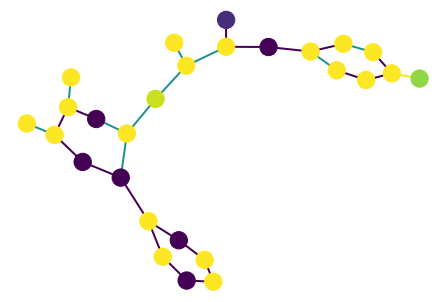

In [99]:
n = 0

G = nx.Graph()
G.add_nodes_from(range(len(graph_list[n][0])))
G.add_edges_from(graph_list[n][1][:,:2])
nx.draw(G, pos=nx.spring_layout(G), node_color=graph_list[n][0], width = 2, edge_color=graph_list[n][1][:,2])  # use spring layout

In [100]:
samples_mol_rnn[n]

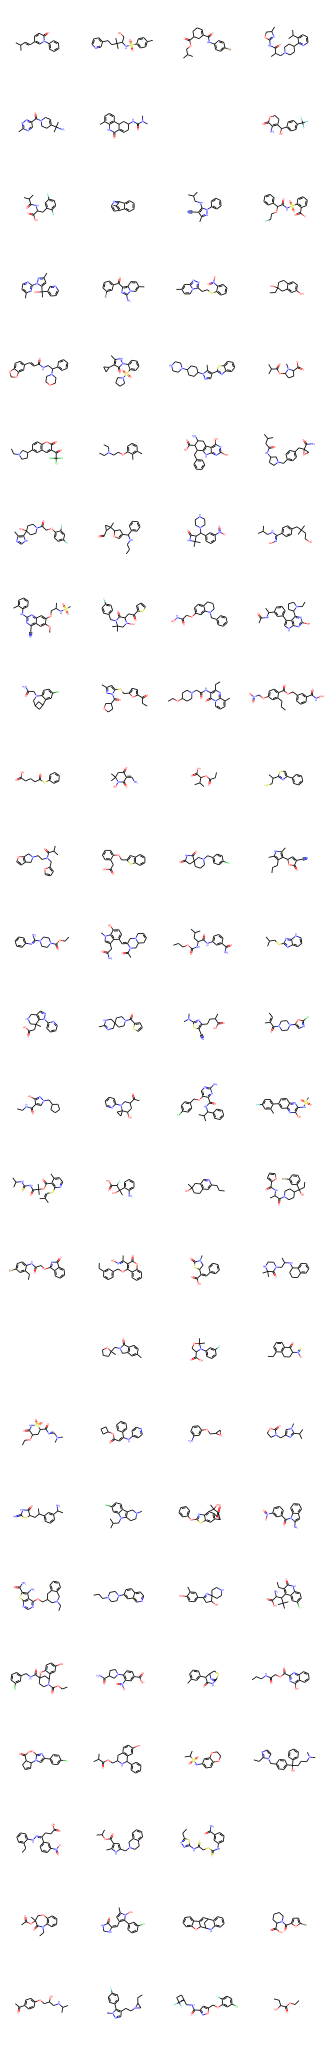

In [98]:
#random.shuffle(samples_mol_rnn)
Draw.MolsToGridImage(samples_mol_rnn, molsPerRow=4, maxMols = 100)